Enemble Learning
* 유형
- 보팅 (Voting)
- 배깅 (Bagging)
- 부스팅 (Boosting)

* 배깅
- 랜덤 포레스트(Random Forest)
* 부스팅
- 에이다 부스팅, 그래디언트 부스팅, XGBoost, LightGBM

In [2]:
# 필요한 모듈과 데이터 불러오기
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## sklearn.ensemble.VotingClassifier
* class sklearn.ensemble.VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)

In [3]:
# 보팅 적용을 위한 개별 모델은 로지스틱 회귀와 KNN입니다.
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별모델을 소프트보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[ ('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

# 데이터를 훈련셋과 테스트셋으로 나누기
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# 보팅 분류기의 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기의 정확도: {0: .4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기의 정확도:  0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


## sklearn.ensemble.RandomForestClassifier
* class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1])
                                                                                                            if x[1] > 0 else x[0], axis=1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('../datasets/UCI HAR Dataset/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 반환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
    # 컬럼명은 feature_name 적용
    X_train = pd.read_csv('../datasets/UCI HAR Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('../datasets/UCI HAR Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('../datasets/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('../datasets/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return X_train, X_test, y_train, y_test

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

In [7]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

KeyboardInterrupt: 

In [39]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/Users/taewon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/taewon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/taewon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/taewon/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_va

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [8]:
rf_clf1 = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=8,\
                                 min_samples_split=8, random_state=0, n_jobs=-1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9230


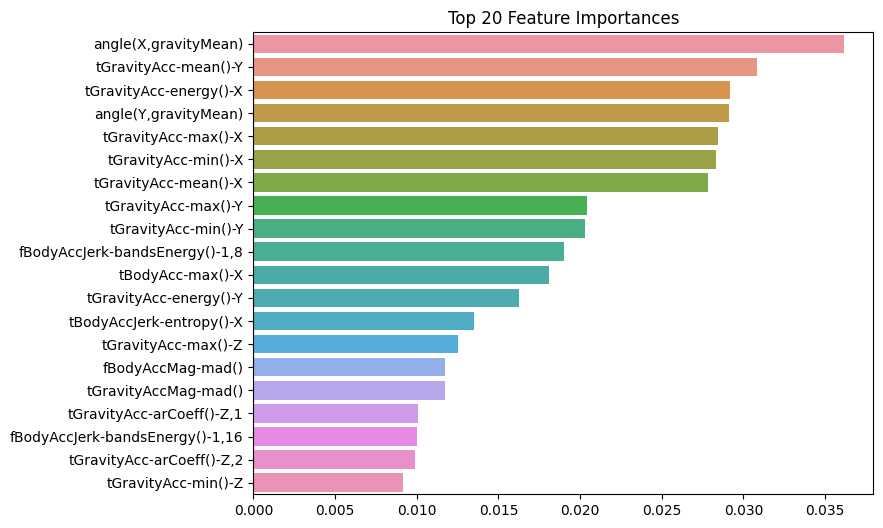

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## Boosting
* 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 토해 오류를 개선해 나가면서 학습하는 방식입니다.
* 부스팅 알고리즘은 대표적으로 아래와 같은 알고리즘들이 있습니다.
    - AdaBoost
    - Gradient Boosting Machine(GBM)
    - XGBoost
    - LightGBM
    - CatBoost

## AdaBoost
* Adaptive Boost의 줄임말로서 약한 학습기(weak learner)의 오류 데이터에 가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘
* 속도나 성능적인 측면에서 decision tree를 약한 학습기로 사용

## Gradient Boost Machine(GBM)
* AdaBoost와 유사하지만, 가중치 업데이트를 경사하강법(Gradient Descent)를 이용하여 최적화된 결과를 얻는 알고리즘
* 오류 값은 실제 값 - 예측값
* GBM은 예측 성능이 높지만 Greedy Algorithm으로 과적합이 빠르게 되고, 시간이 오래 걸린다는 단점이 있음
- 경사하강법
    * 분류의 실제값을 y, 피처에 기반한 예측함수를 F(x), 오류식을 h(x) = y-F(x)라고 하면 이 오류식을 최소화하는 방향성을 가지고 가중치 값을 업데이트
- Greedy Algorithm(탐욕 알고리즘)
    * 미래를 생각하지 않고 각 단계에서 가장 최선의 선택을 하는 기법으로 각 단계에서 최선의 선택을 한 것이 전체적으로도 최선이길 바라는 알고리즘
    * 물론 모든 경우에서 그리디 알고리즘이 통하지는 않음

### sklearn.ensemble.GradientBoostingClassifier
* class sklearn.ensemble.GradientBoostingClassifier(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간 : {0:.1f}초'.format(time.time() - start_time))

KeyboardInterrupt: 

In [44]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100, 500],
          'learning_rate': [0.05, 0.1]}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# GridSearchCV를 이용해 최적으로 학습된 estimators로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

## XGBoost
### https://xgboost.readthedocs.io/en/stable/# 

- 주요 장점
    * 뛰어난 예측 성능
    * GBM 대비 빠른 수행 시간
    * 과적합 규제(Overfitting Regularization)
    * Tree Pruning(트리 가지치기) : 긍정 이득이 없는 분할을 가지치기해서 분할 수를 줄임
    * 자체 내장된 교차 검증
        - 반복 수행시 마다 내부적으로 교차검증을 수행하여 최적화된 반복 수행횟수를 가질 수 있음
        - 지정된 반복 횟수가 아라 교차검증을 통해 평가 데이트세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 기능이 있음
    * 결손값 자체 처리

In [11]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [12]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [13]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


* 파이썬래퍼 XGBoost와 사이킷런래퍼 XGBoost의 가장 큰 차이는 파이썬래퍼는 학습용과 테스트 데이터 세트를 위해 별도의 DMatrix를 생성한다는 것
* DMatrix : 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트
    - 주요 입력 파라미터는 data(피처 데이터 세트)와 label (분류: 레이블 데이터 세트/회귀: 숫자형인 종속값 데이터 세트)
    - 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차변환 한 뒤에 DMatrix 변환을 적용

In [14]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [15]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400

* 파이썬래퍼 XGBoost에서 하이퍼 파라미터를 xgboost 모듈의 train( ) 함수에 파라미터로 전달합니다.
* (사이킷런 래퍼는 Estimator 생성자를 하이퍼 파라미터로 전달)
* early_stopping_rounds 파라미터 : 조기 중단을 위한 라운드를 설정합니다.
* 조기 중단 기능 수행을 위해서는 반드시 eval_set과 eval_metric이 함께 설정되어야 합니다.
* eval_set : 성능평가를 위한 평가용 데이터 세트를 설정
* eval_metric : 평가 세트에 적용할 성능 평가 방법
* (반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정)
* train() 함수를 호출하면 xgboost가 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표를 출력합니다. 
* 그 후 학습이 완료된 모델 객체를 반환합니다.

In [16]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[15:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	t

In [17]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [18]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [19]:
get_clf_eval(y_test, preds)

오차행렬:
 [[35  2]
 [ 1 76]]

정확도: 0.9737
정밀도: 0.9744
재현율: 0.9870
F1: 0.9806
AUC: 0.9665


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

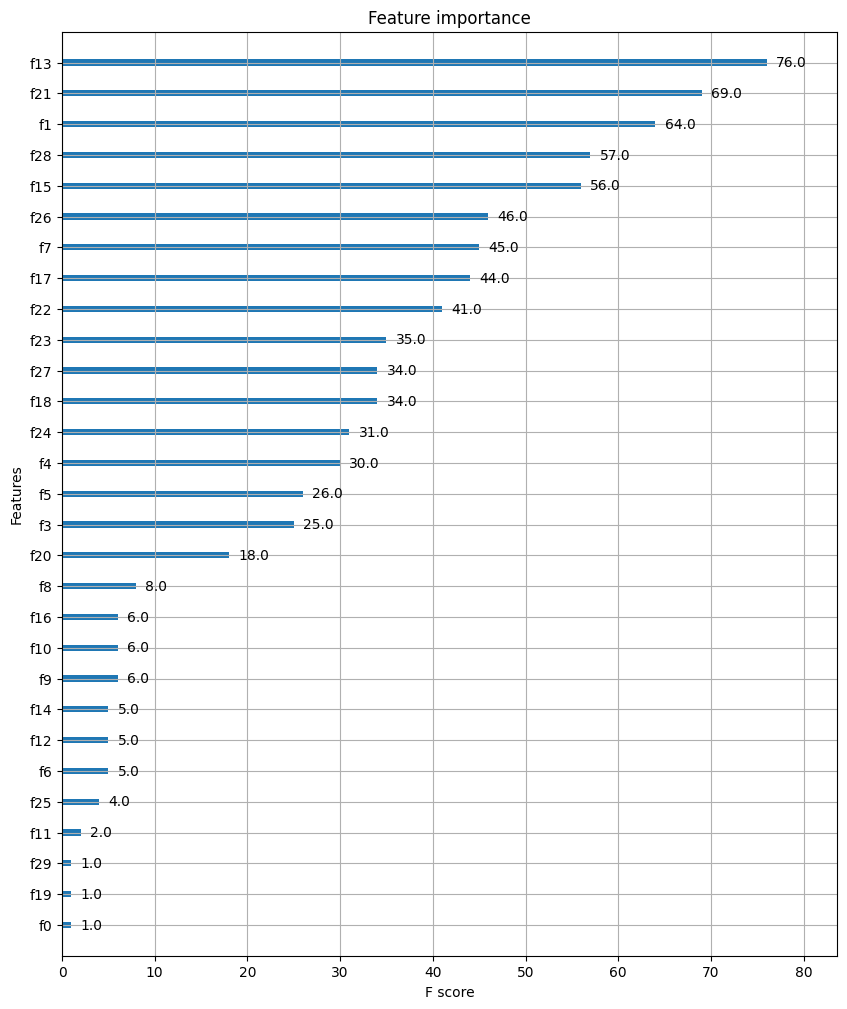

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [21]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 부스팅 반복횟수는 400

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

In [22]:
# 예측 결과 확인
get_clf_eval(y_test, w_preds)

오차행렬:
 [[35  2]
 [ 1 76]]

정확도: 0.9737
정밀도: 0.9744
재현율: 0.9870
F1: 0.9806
AUC: 0.9665


In [23]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

# 아래 예제에서는 평가를 위한 데이터 세트로 테스트 데이터 세트를 사용했지만, 바람직하진 않습니다.
# 테스트 데이터 세트는 학습에 완전히 알려지지 않은 데이터 세트를 사용해야 합니다.
# 평가에 테스트 데이터 세트를 사용하면 학습시에 미리 참고가 되어 과적합할 수 있기 때문입니다.

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1 , max_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, 
                eval_metric="logloss", eval_set = evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [24]:
get_clf_eval(y_test, ws100_preds)

오차행렬:
 [[34  3]
 [ 1 76]]

정확도: 0.9649
정밀도: 0.9620
재현율: 0.9870
F1: 0.9744
AUC: 0.9530


In [25]:
# early_stopping_rounds = 10 으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, 
                eval_metric='logloss', eval_set=evals , verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
get_clf_eval(y_test, ws10_preds)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

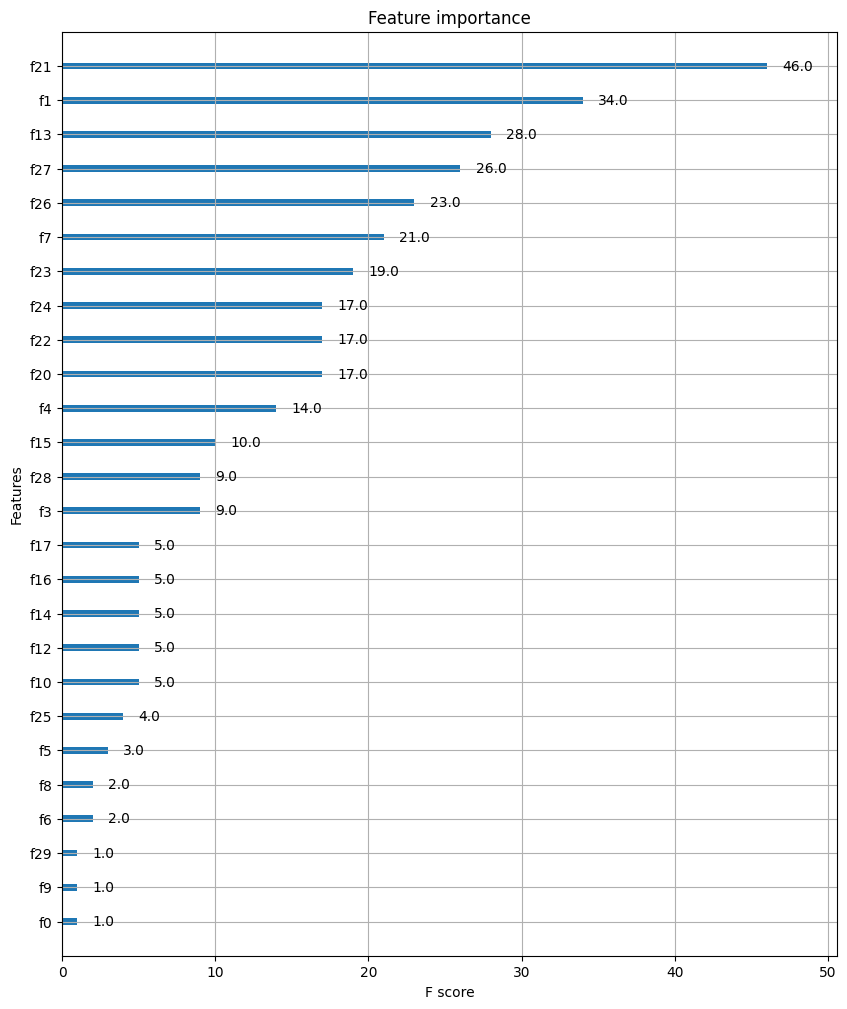

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax)

## sklearn.tree.DecisionTreeRegressor
* class sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)

## sklearn.svm: Support Vector Machines
### https://bkshin.tistory.com/entry/머신러닝-2서포트-벡터-머신-SVM
### https://hleecaster.com/ml-svm-concept/

In [50]:
from sklearn.datasets import load_iris
iris=load_iris()
x=iris.data
y=iris.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data,iris.target, test_size=0.5, random_state=42)

In [51]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

dt_clf= svm.SVC()
dt_clf.fit(X_train,y_train)

params={
    'gamma' : [0.1,0.05,0.01],
    'C' :[100,10]
}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print(f"GridSearchCV 최고 평균 정확도 수치{grid_cv.best_score_:.4f}")
print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV 최고 평균 정확도 수치0.9467
GridSearchCV 최적 하이퍼 파라미터: {'C': 10, 'gamma': 0.05}


In [52]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)

In [53]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(y_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

[2 2 1 0 1 0 2 0 2 1 0 1 1 1 2 1 0 2 0 0 0 2 1 1 1 0 0 1 0 2 0 0 0 1 0 1 0
 2 0 1 0 2 0 0 0 2 0 1 1 2 1 2 0 0 1 2 1 0 2 2 2 0 1 1 0 1 2 0 1 1 0 2 1 1
 2]
0.9733333333333334


## kNN 알고리즘
* k - Nearest Neighbor(kNN) 알고리즘은 모든 기계 학습 알고리즘 중에서도 가장 간단하고 이해하기 쉬운 분류 알고리즘
* 특징 공간에 있는 모든 데이터에 대한 정보가 필요함
* 가장 가까운 이웃을 찾기 위해 새로운 데이터에서 모든 기존 데이터까지의 거리를 확인해야 하기 때문
* 데이터와 클래스가 많이 있다면, 많은 메모리 공간과 계산 시간이 필요함

* 어떤 종류의 학습이나 준비 시간이 필요 없음

In [55]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.feature_names)
print(iris.target_names)
print(iris.data[0])
print(iris.target[0])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[5.1 3.5 1.4 0.2]
0


In [57]:
from sklearn.datasets import load_iris
iris = load_iris()
for i in range(len(iris.target)):
    print('Example %d: label %s, features %s' % (i, iris.target[i], iris.data[i]))

Example 0: label 0, features [5.1 3.5 1.4 0.2]
Example 1: label 0, features [4.9 3.  1.4 0.2]
Example 2: label 0, features [4.7 3.2 1.3 0.2]
Example 3: label 0, features [4.6 3.1 1.5 0.2]
Example 4: label 0, features [5.  3.6 1.4 0.2]
Example 5: label 0, features [5.4 3.9 1.7 0.4]
Example 6: label 0, features [4.6 3.4 1.4 0.3]
Example 7: label 0, features [5.  3.4 1.5 0.2]
Example 8: label 0, features [4.4 2.9 1.4 0.2]
Example 9: label 0, features [4.9 3.1 1.5 0.1]
Example 10: label 0, features [5.4 3.7 1.5 0.2]
Example 11: label 0, features [4.8 3.4 1.6 0.2]
Example 12: label 0, features [4.8 3.  1.4 0.1]
Example 13: label 0, features [4.3 3.  1.1 0.1]
Example 14: label 0, features [5.8 4.  1.2 0.2]
Example 15: label 0, features [5.7 4.4 1.5 0.4]
Example 16: label 0, features [5.4 3.9 1.3 0.4]
Example 17: label 0, features [5.1 3.5 1.4 0.3]
Example 18: label 0, features [5.7 3.8 1.7 0.3]
Example 19: label 0, features [5.1 3.8 1.5 0.3]
Example 20: label 0, features [5.4 3.4 1.7 0.2]
Ex

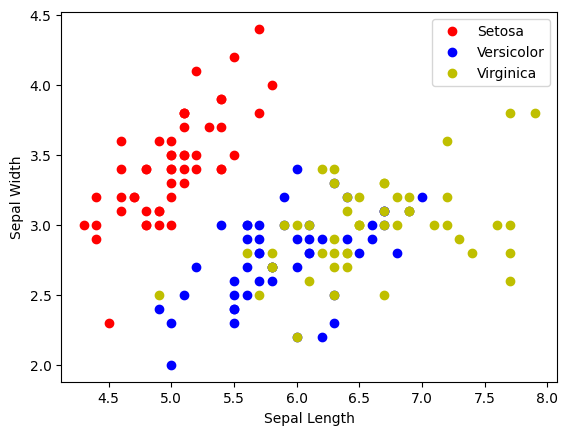

In [63]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
iris = load_iris()
sepal = iris.data[:,0:2]
kind = iris.target
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.plot(sepal[kind==0][:,0], sepal[kind==0][:,1], "ro",label='Setosa')
plt.plot(sepal[kind==1][:,0], sepal[kind==1][:,1], "bo",label='Versicolor')
plt.plot(sepal[kind==2][:,0], sepal[kind==2][:,1], "yo",label='Virginica')
plt.legend()